<a href="https://colab.research.google.com/github/kiplangatkorir/-Time-Series-Forecasting-of-Stock-Prices/blob/main/time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance

In [2]:
import yfinance as yf
import pandas as pd

In [4]:
# Define the ticker symbol and download data
ticker = 'AAPL'  # Apple Inc.
data = yf.download(ticker, start='2015-01-01', end='2022-12-31')
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.435266,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.746891,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.749123,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.082136,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,25.007429,237458000


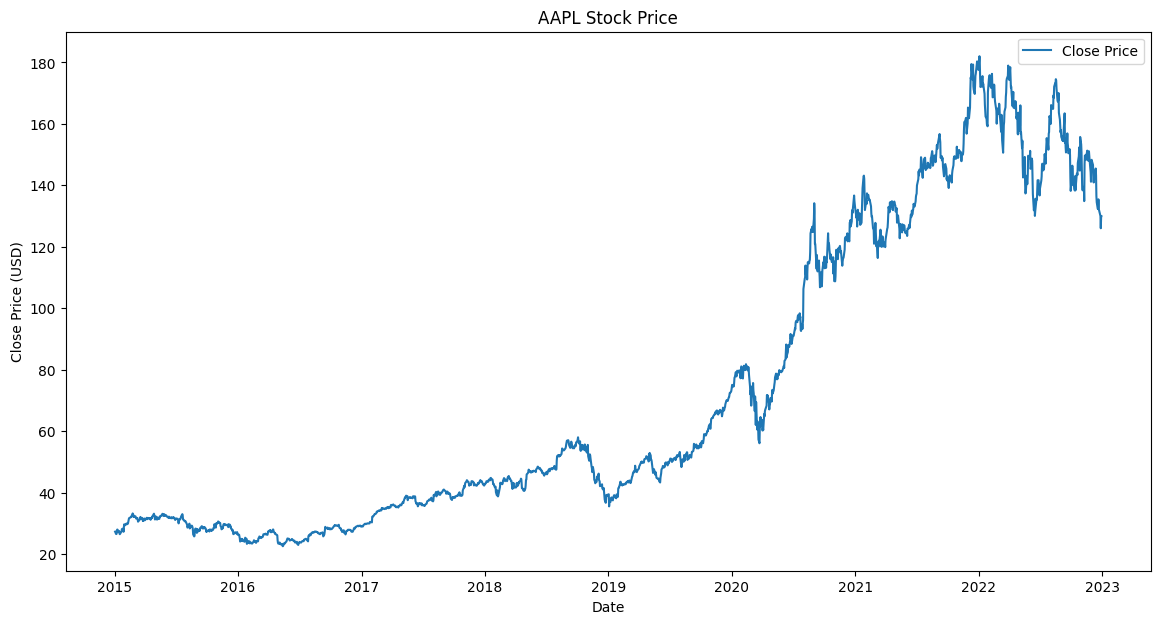

In [5]:
import matplotlib.pyplot as plt

# Plot the closing prices
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Close Price')
plt.title(f'{ticker} Stock Price')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()


In [6]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Preprocess the data
data = data[['Close']]  # Use only the closing price
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create a function to prepare the dataset for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

# Prepare the training and testing datasets
time_step = 60  # Number of previous time steps to consider
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape the input data to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}')


Epoch 1/10
25/25 [==============================] - 12s 232ms/step - loss: 0.0130 - val_loss: 0.0324
Epoch 2/10
25/25 [==============================] - 2s 88ms/step - loss: 6.6673e-04 - val_loss: 0.0020
Epoch 3/10
25/25 [==============================] - 3s 120ms/step - loss: 3.8455e-04 - val_loss: 0.0019
Epoch 4/10
25/25 [==============================] - 2s 73ms/step - loss: 3.5642e-04 - val_loss: 0.0019
Epoch 5/10
25/25 [==============================] - 2s 71ms/step - loss: 3.2714e-04 - val_loss: 0.0018
Epoch 6/10
25/25 [==============================] - 2s 72ms/step - loss: 3.4228e-04 - val_loss: 0.0022
Epoch 7/10
25/25 [==============================] - 2s 71ms/step - loss: 4.2078e-04 - val_loss: 0.0022
Epoch 8/10
25/25 [==============================] - 2s 71ms/step - loss: 3.9843e-04 - val_loss: 0.0020
Epoch 9/10
25/25 [==============================] - 2s 93ms/step - loss: 3.1587e-04 - val_loss: 0.0024
Epoch 10/10
11/11 [==============================] - 0s 18ms/step - loss: 

In [7]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions and the actual values
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Calculate the root mean squared error (RMSE)
train_rmse = np.sqrt(np.mean(((train_predict - y_train[0]) ** 2)))
test_rmse = np.sqrt(np.mean(((test_predict - y_test[0]) ** 2)))
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')


11/11 [==============================] - 0s 16ms/step
Train RMSE: 44.540730980681474
Test RMSE: 16.21821468661627


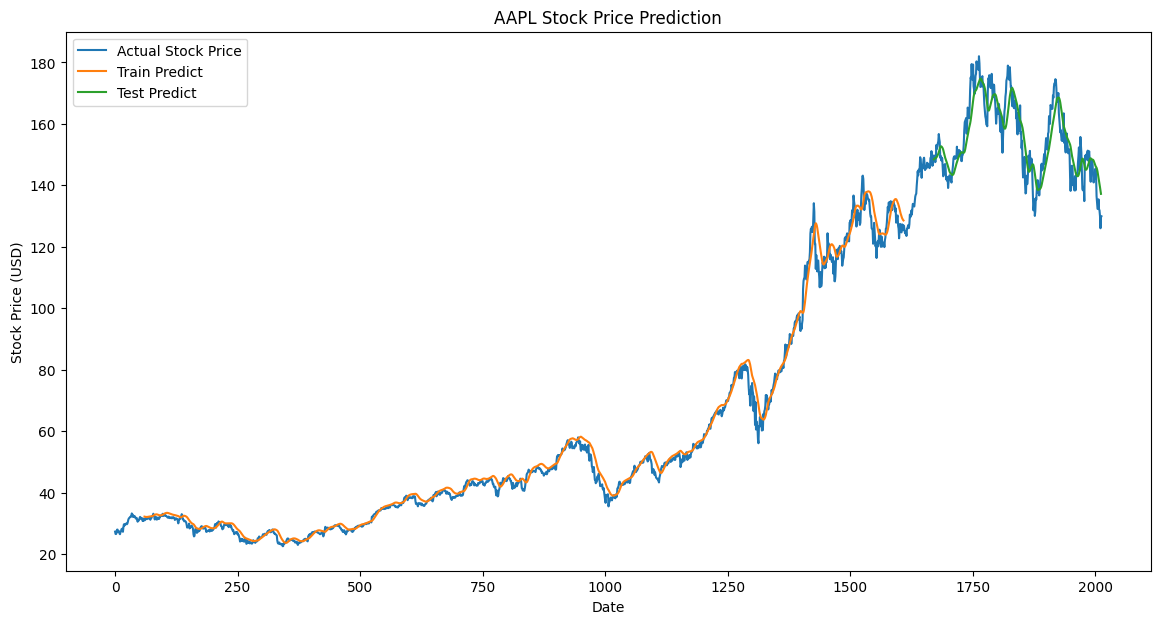

In [8]:
# Shift train predictions for plotting
train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[time_step:len(train_predict) + time_step, :] = train_predict

# Shift test predictions for plotting
test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan
test_plot[len(train_predict) + (time_step * 2) + 1:len(scaled_data) - 1, :] = test_predict

# Plot baseline and predictions
plt.figure(figsize=(14, 7))
plt.plot(scaler.inverse_transform(scaled_data), label='Actual Stock Price')
plt.plot(train_plot, label='Train Predict')
plt.plot(test_plot, label='Test Predict')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()
